In [3]:
import os, sys
import numpy as np
from astropy import units
from astropy.io import fits
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize, curve_fit
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks, gaussian
from scipy.interpolate import interp1d
from lmfit import Model

import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

from stella.utils import flare_lightcurve

%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

## PROPOSAL ID 16164
plt.rcParams['font.size']=18

wavelength, flux, err = load_binned_data('/Users/arcticfox/Documents/AUMic/reduced/binned_data_a.npy')
wavelength2, flux2, err2 = load_binned_data('/Users/arcticfox/Documents/AUMic/reduced2/binned_data2.npy')

times = np.load('/Users/arcticfox/Documents/AUMic/reduced/times.npy')
orbits = np.load('/Users/arcticfox/Documents/AUMic/reduced/orbits.npy')
times2 = np.load('/Users/arcticfox/Documents/AUMic/reduced2/times.npy')
orbits2 = np.load('/Users/arcticfox/Documents/AUMic/reduced2/orbits.npy')+5

wavelength = np.full(flux.shape, wavelength)
wavelength2 = np.full(flux2.shape, wavelength2)

_, flare_orbits, flare_mask = np.load('/Users/arcticfox/Documents/AUMic/flare_mask.npy',
                                      allow_pickle=True)

parula = np.load('/Users/arcticfox/parula_colors.npy')

distance = (9.79*units.pc).to(units.cm)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
fwc = FlaresWithCOS(wavelength=np.append(wavelength, wavelength2, axis=0), 
                    flux=np.append(flux, flux2, axis=0),
                    flux_err=np.append(err, err2, axis=0), 
                    time=np.append(times, times2)-times[0], 
                    orbit=np.append(orbits, orbits2))
fwc.load_line_table(path='/Users/arcticfox/Documents/GitHub/cos_flares/')
fwc.load_lsf_model(fname='/Users/arcticfox/Documents/AUMic/aa_LSFTable_G130M_1222_LP4_cn.dat')

## Line fitting

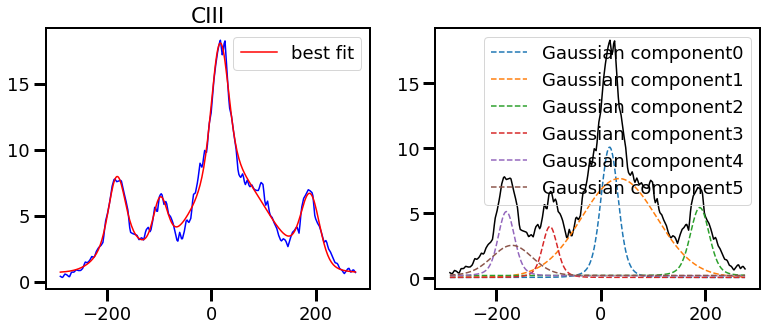

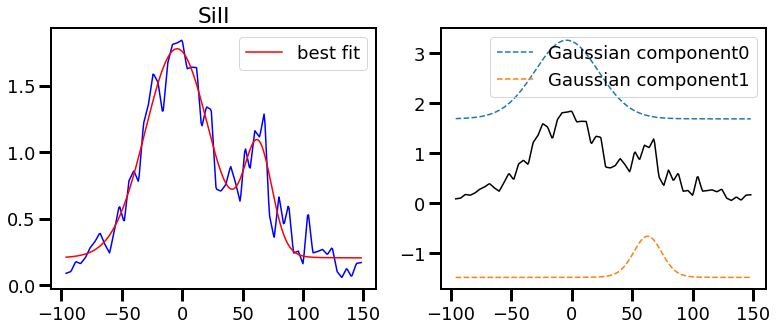

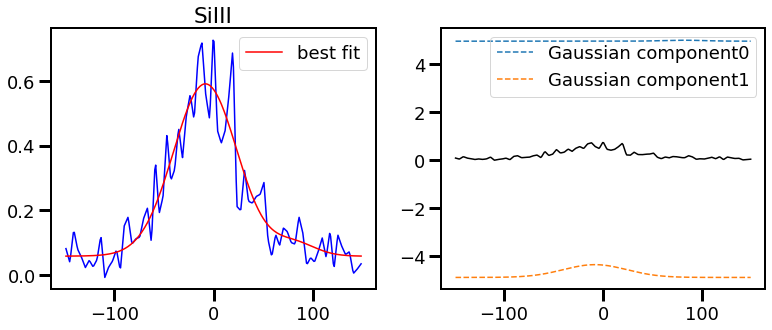

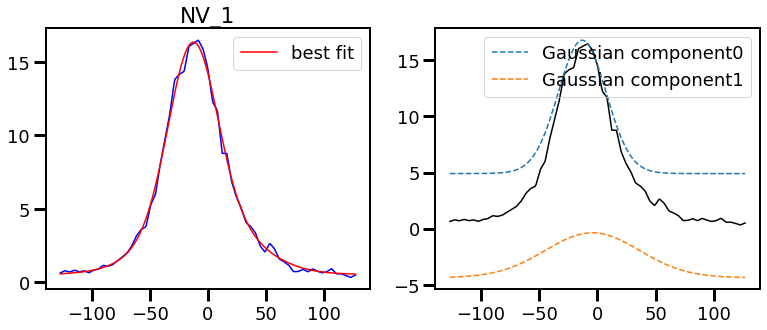

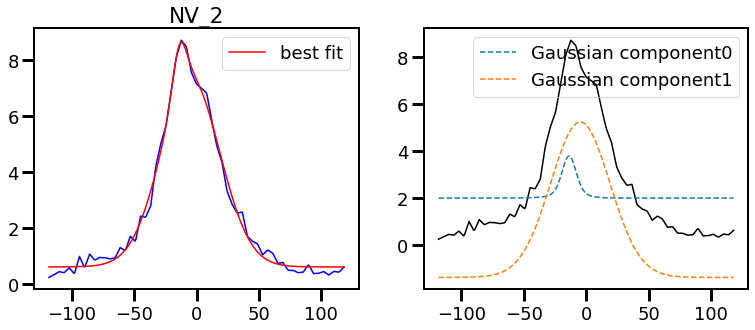

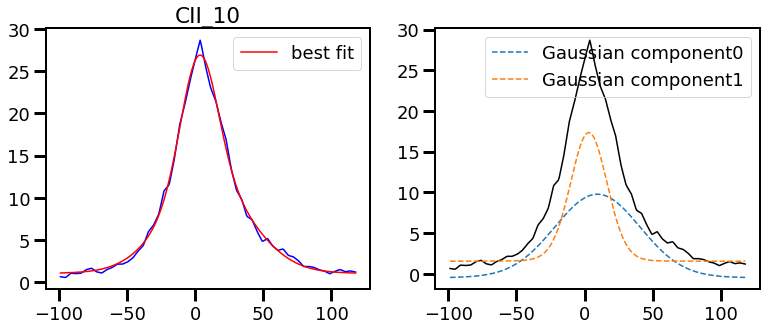

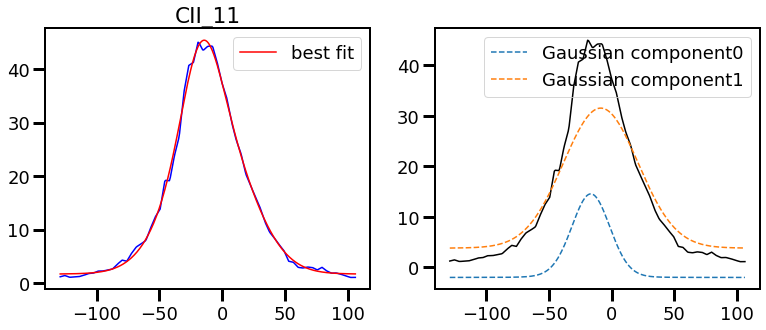

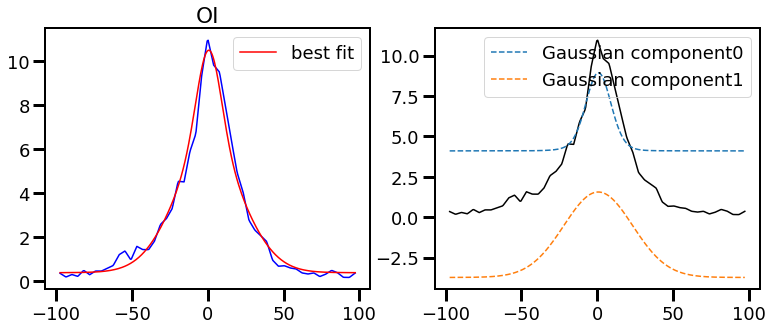

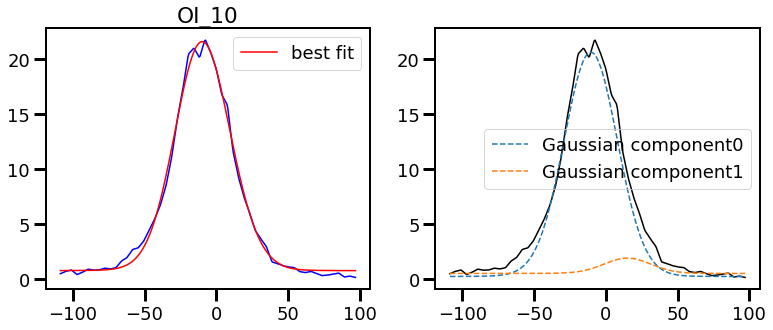

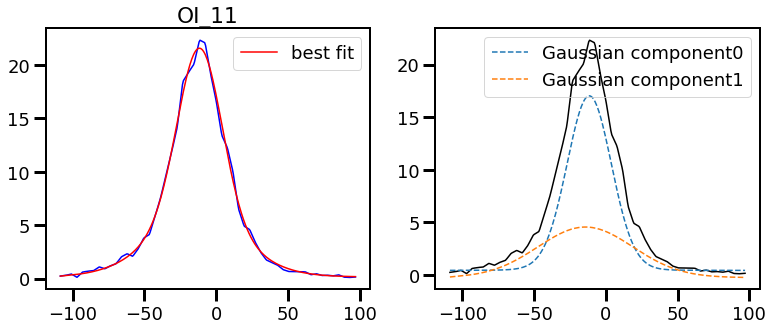

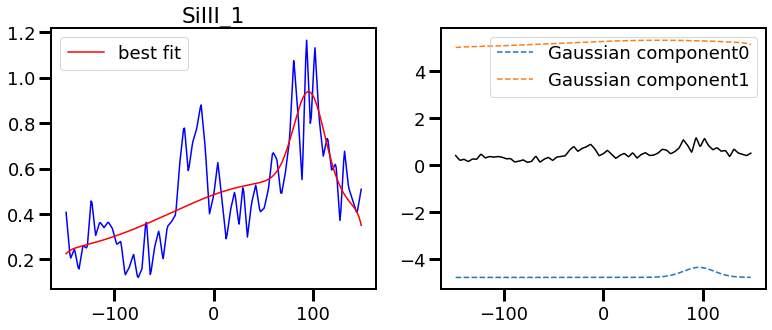

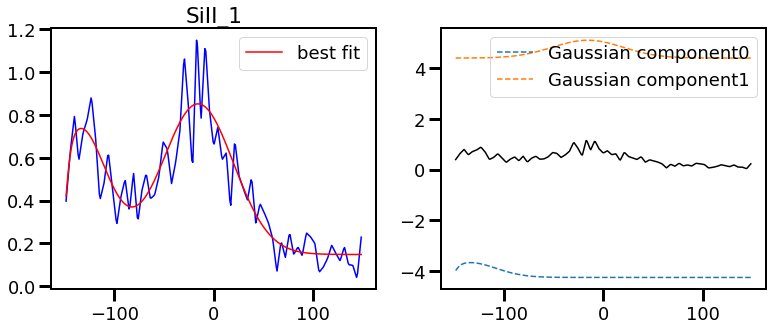

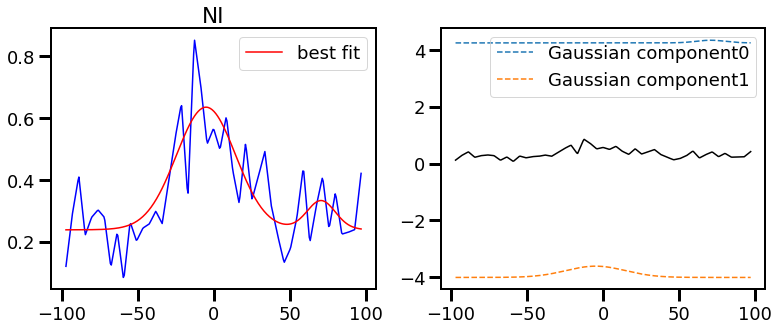

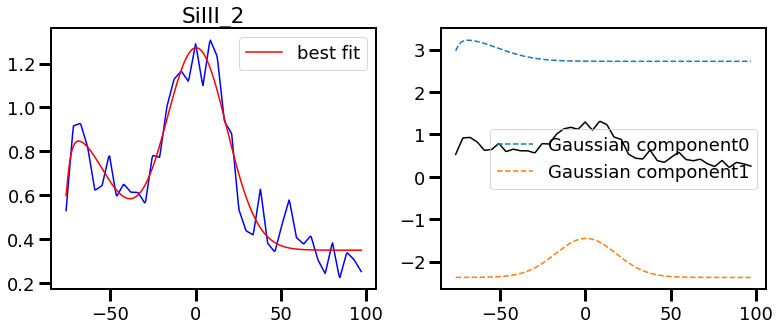

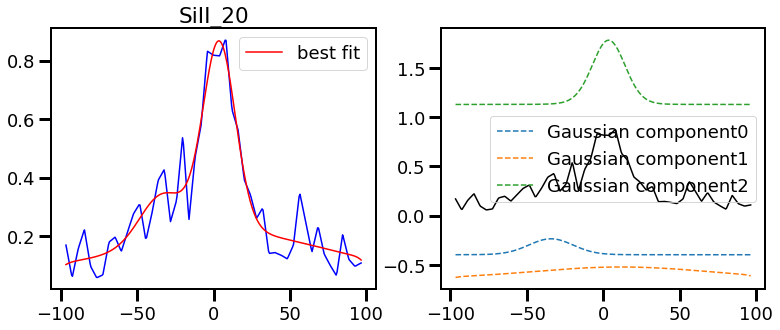

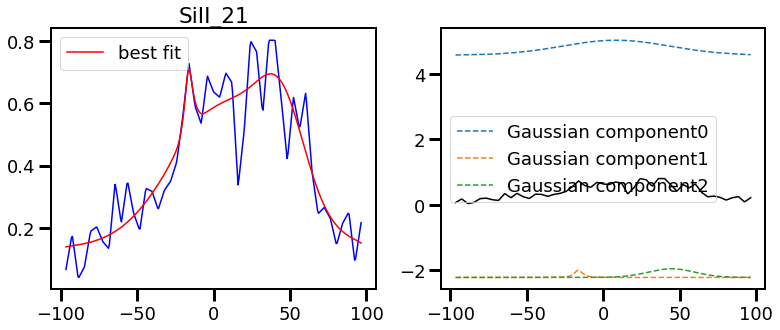

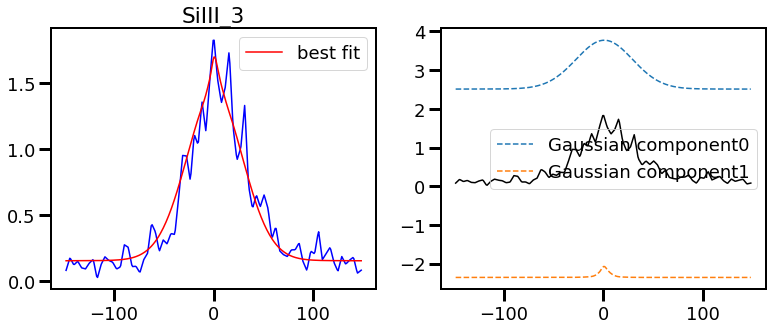

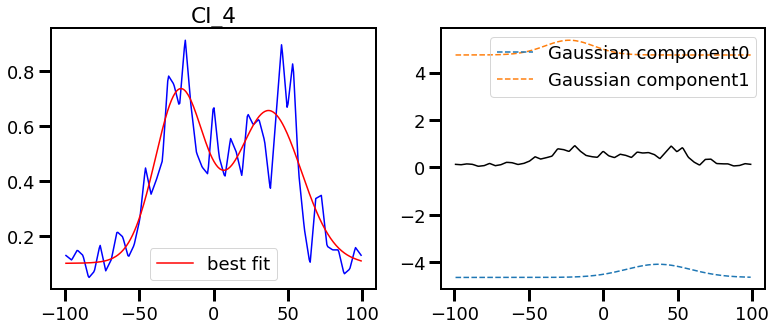

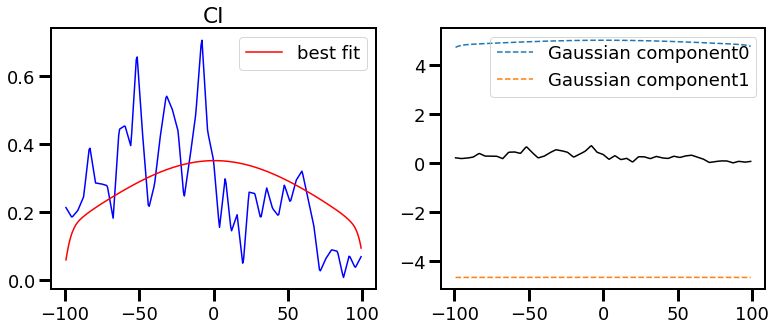

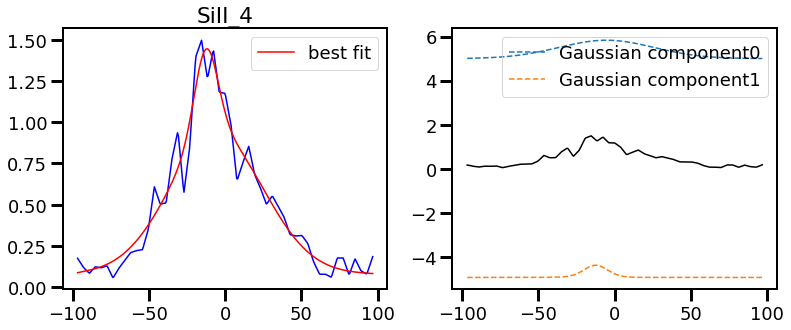

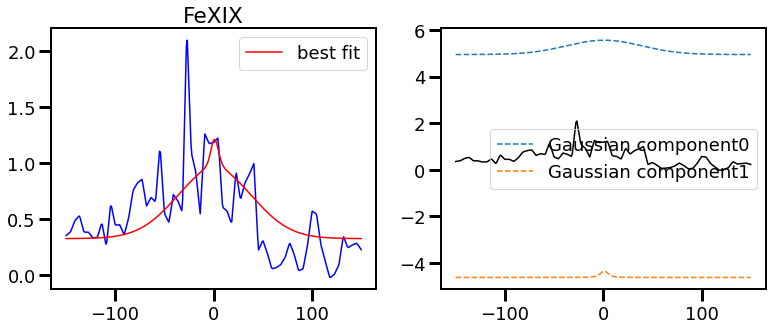

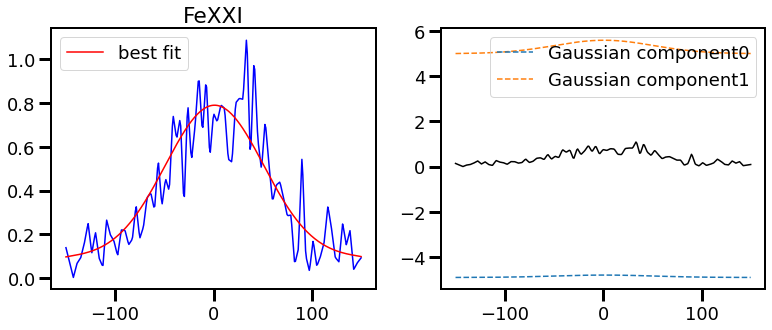

In [5]:
oot = (fwc.orbit == flare_orbits[2]) & (flare_mask[2] == 0)
it = (fwc.orbit == flare_orbits[2]) & (flare_mask[2] != 0)

oof_values = []

for i in range(len(fwc.line_table)):
    if i == 1:
        ngauss = fwc.line_table['ngauss'][i] -1
    else:
        ngauss = fwc.line_table['ngauss'][i]
    args = fwc.model_line_shape(ion=fwc.line_table['ion'][i], 
                                mask=oot, 
                                ngauss=ngauss, 
                                ext=50)
    oof_values.append(args)
    
    fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
    axes[0].plot(args[0], args[1], 'b')
    #axes[0].plot(vel, init, 'k--', label='initial fit')
    axes[0].plot(args[0], args[-1].best_fit, 'r-', label='best fit')
    axes[0].legend(loc='best')
    axes[0].set_title(fwc.line_table['ion'][i])
    comps = args[-1].eval_components(x=args[0])
    axes[1].plot(args[0], args[1], 'k')
    for i in range(ngauss):
        axes[1].plot(args[0], comps['g{}_'.format(i)], '--', label='Gaussian component'+str(i))
    axes[1].legend(loc='best')
    plt.show()

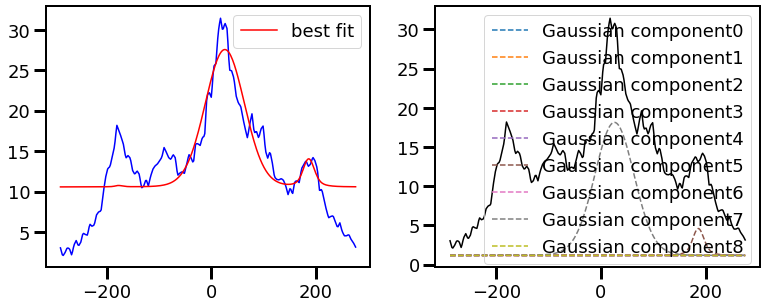

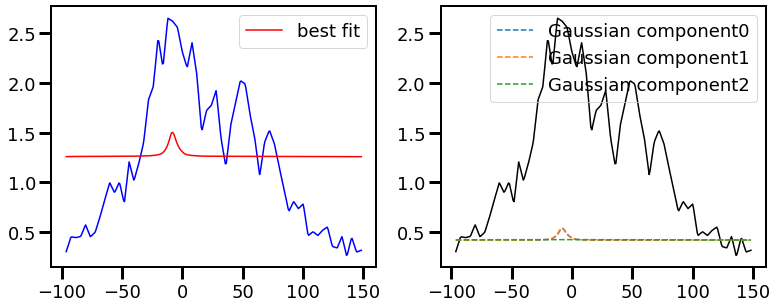

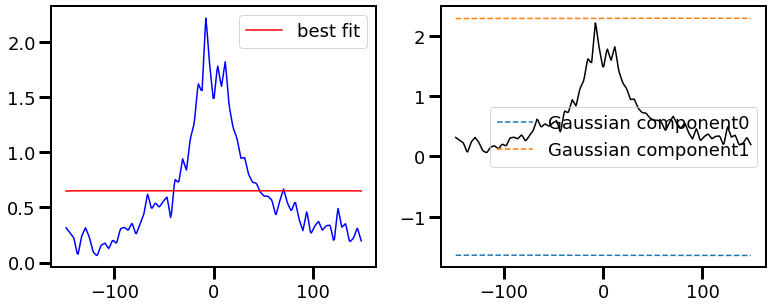

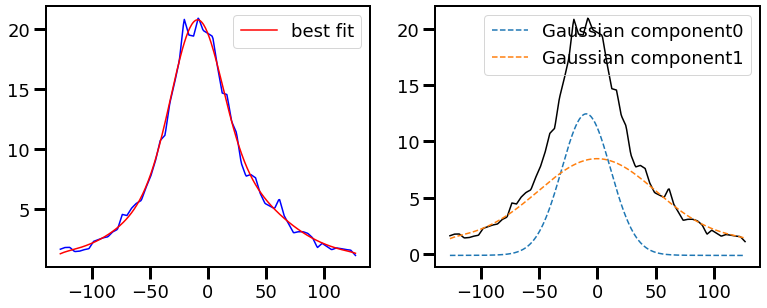

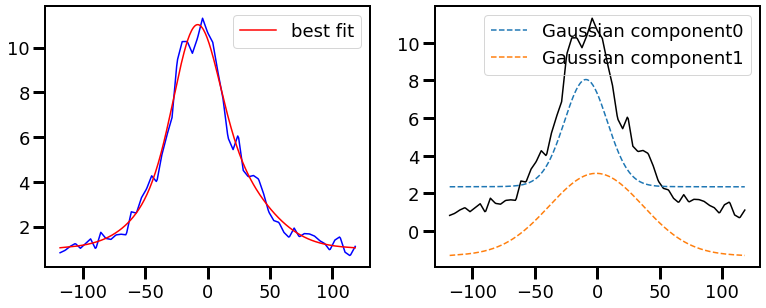

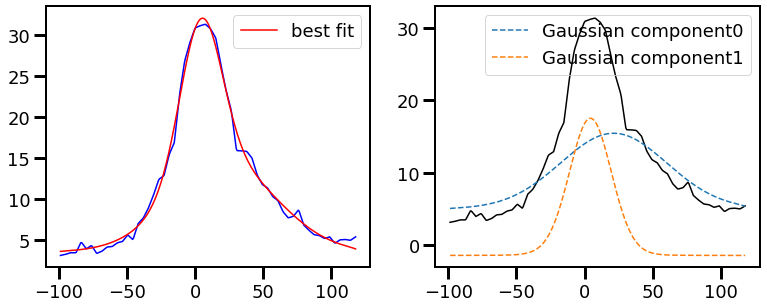

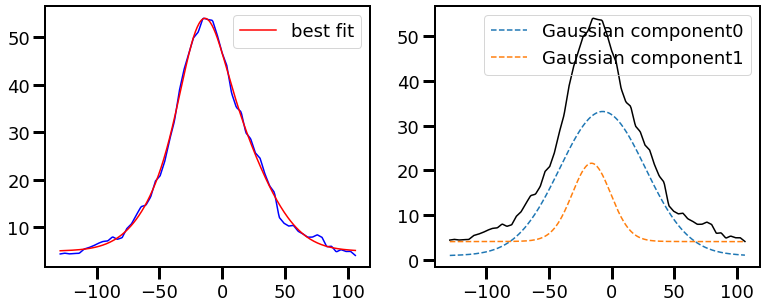

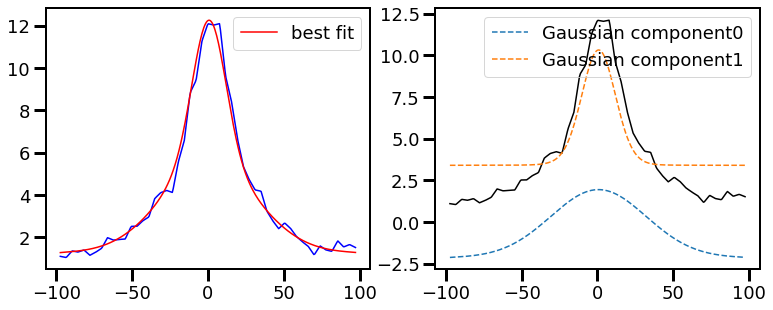

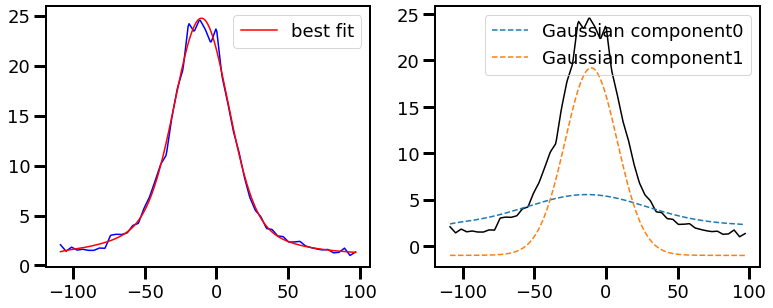

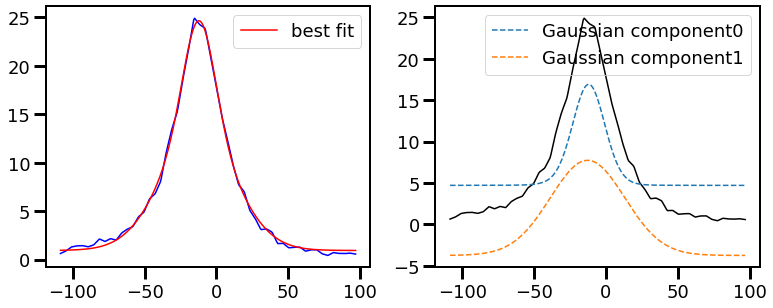

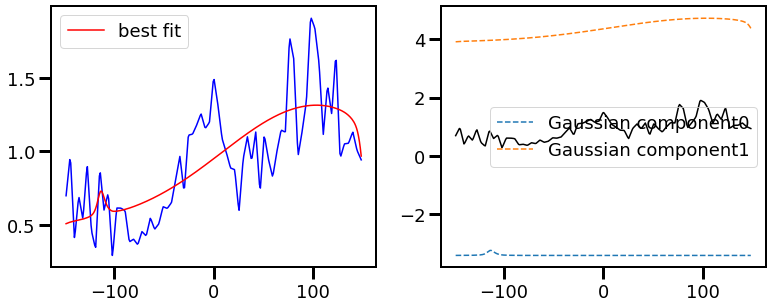

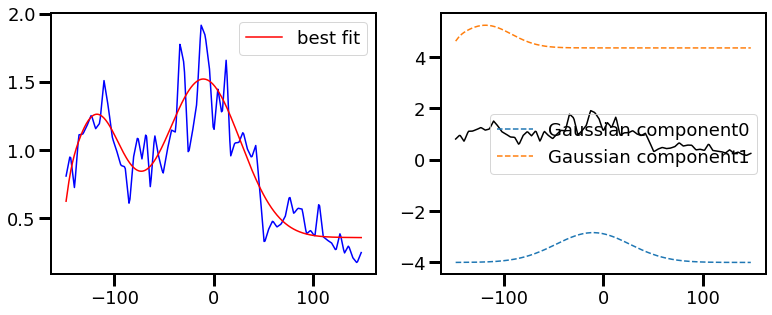

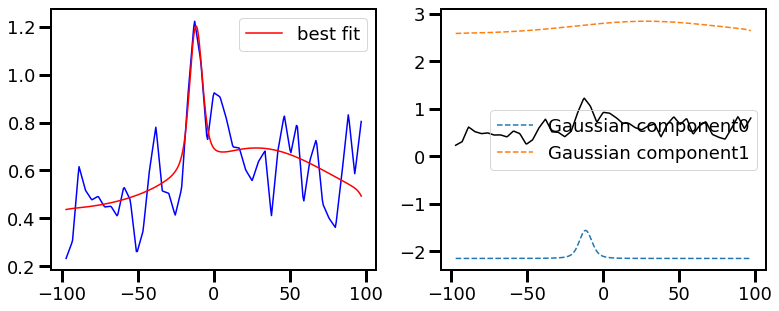

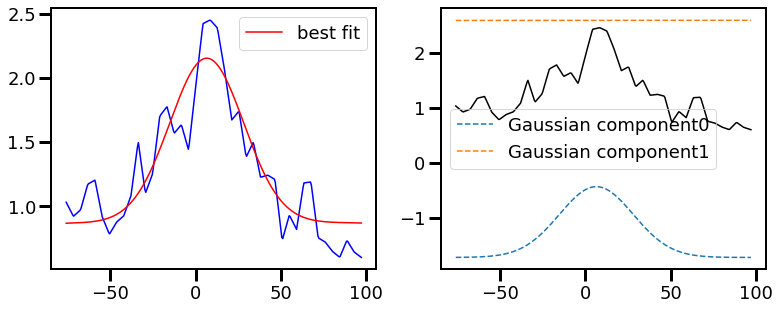

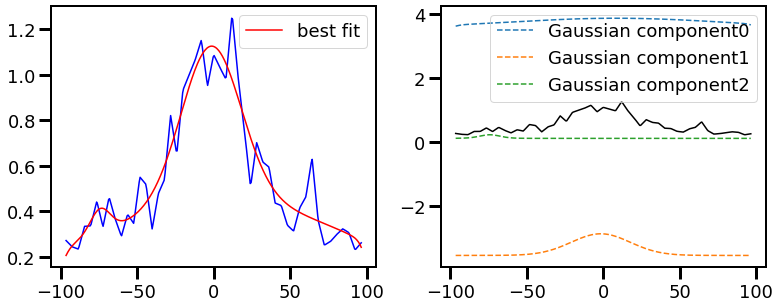

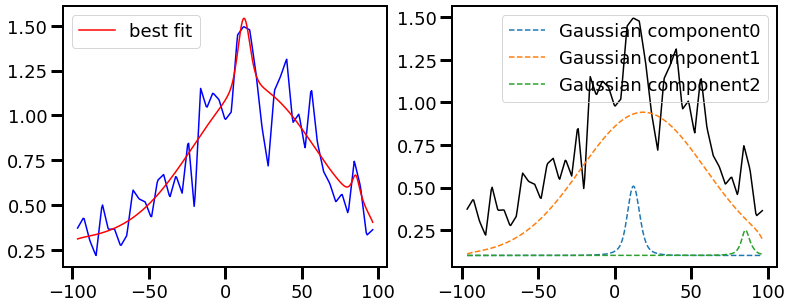

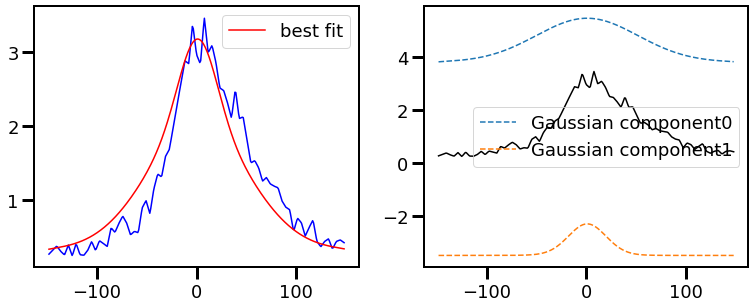

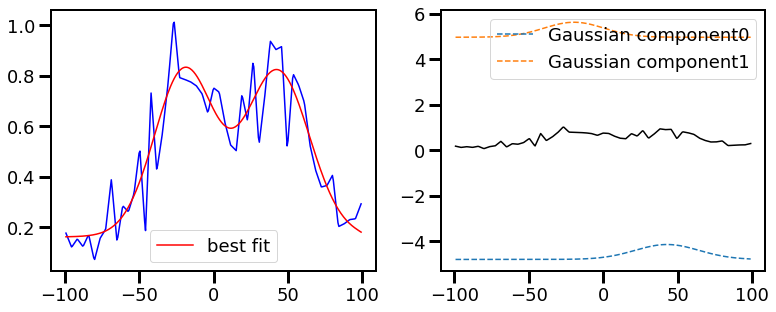

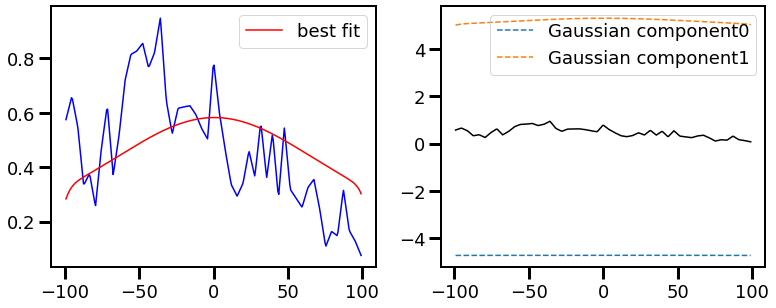

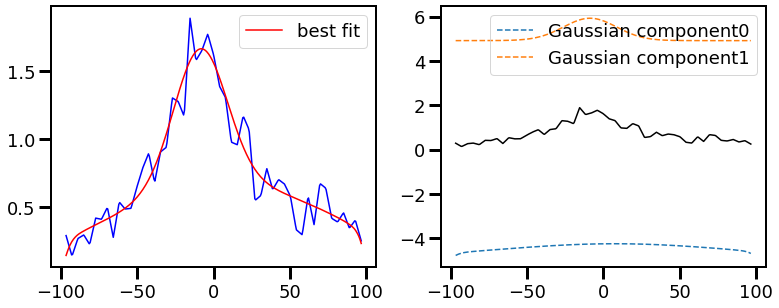

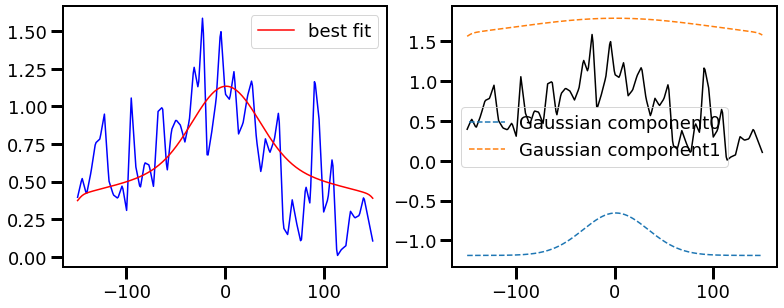

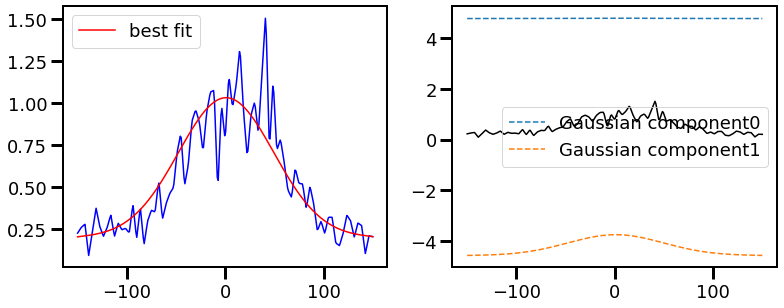

In [6]:
ngauss=4

if_values = []

for i in range(len(fwc.line_table)):
    if i == 0:
        ngauss = fwc.line_table['ngauss'][i]+3
    else:
        ngauss = fwc.line_table['ngauss'][i]+0
        
    args = fwc.model_line_shape(ion=fwc.line_table['ion'][i], 
                                mask=it, 
                                ngauss=ngauss,
                                ext=50)
    if_values.append(args)
    
    fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
    axes[0].plot(args[0], args[1], 'b')
    #axes[0].plot(vel, init, 'k--', label='initial fit')
    axes[0].plot(args[0], args[-1].best_fit, 'r-', label='best fit')
    axes[0].legend(loc='best')

    comps = args[-1].eval_components(x=args[0])
    axes[1].plot(args[0], args[1], 'k')
    for i in range(ngauss):
        axes[1].plot(args[0], comps['g{}_'.format(i)], '--', label='Gaussian component'+str(i))
    axes[1].legend(loc='best')
    plt.show()

3.4753241848274902e+56 erg / s2 8.829441838533341e+56 erg / s2
2.0506029696950962e+55 erg / s2 3.565905177786974e+55 erg / s2
7.147031482856068e+54 erg / s2 2.220008732919562e+55 erg / s2
1.3309857030561346e+56 erg / s2 2.1212373301277805e+56 erg / s2
6.554254977203515e+55 erg / s2 1.0365864399014886e+56 erg / s2
1.8058059088118102e+56 erg / s2 2.900493051187606e+56 erg / s2
3.581789331197476e+56 erg / s2 5.3161026146612385e+56 erg / s2
5.499344908902493e+55 erg / s2 8.751498277790272e+55 erg / s2
1.3496857566550955e+56 erg / s2 1.7504904399595337e+56 erg / s2
1.2459053160232016e+56 erg / s2 1.4825419137714882e+56 erg / s2
1.6448684512613022e+55 erg / s2 3.2151005855831003e+55 erg / s2
1.5377304822618467e+55 erg / s2 3.0420959084606554e+55 erg / s2
7.802738660828871e+54 erg / s2 1.3665772425275626e+55 erg / s2
1.3369910556859976e+55 erg / s2 2.5288400353914025e+55 erg / s2
6.49421603167828e+54 erg / s2 1.2309759541790305e+55 erg / s2
8.923554697793543e+54 erg / s2 1.6887249727652385e+5

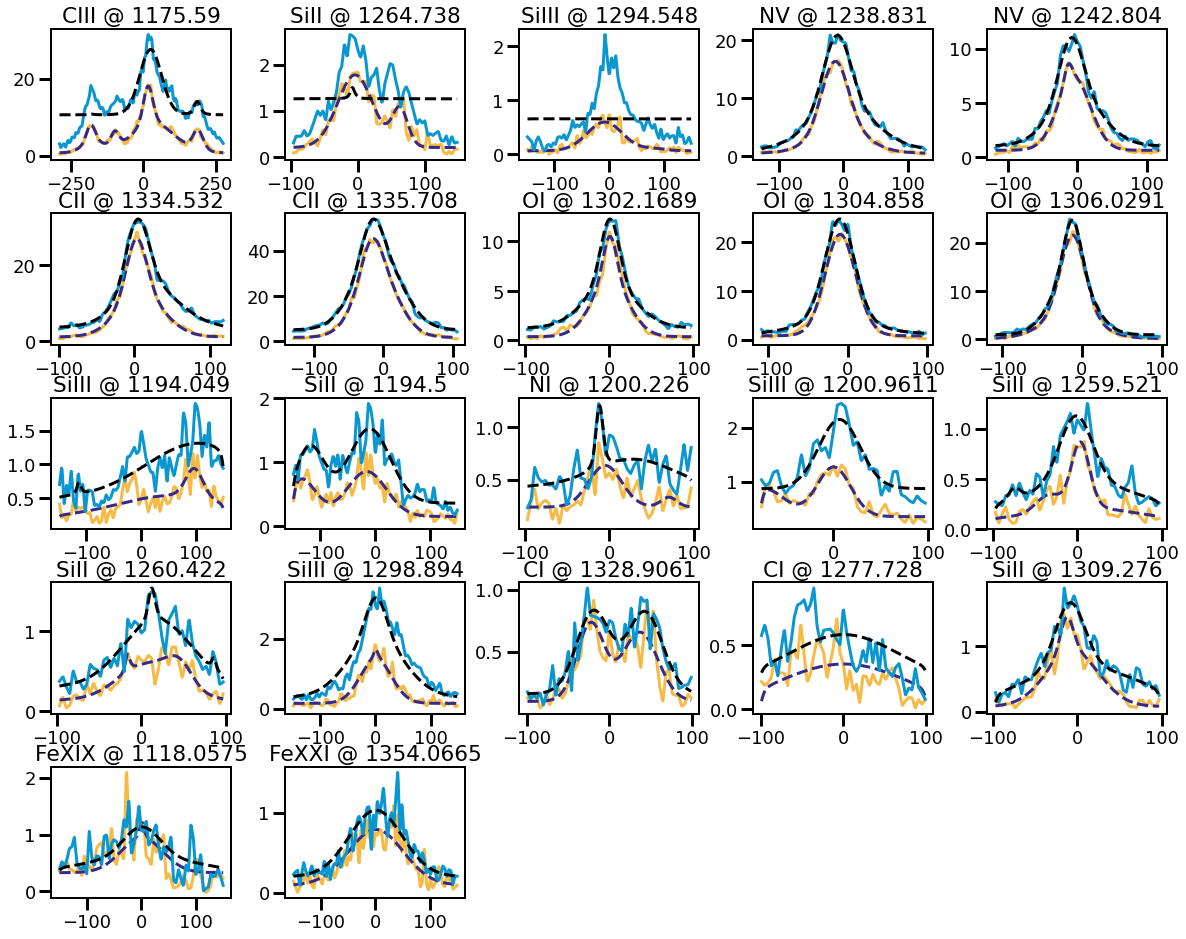

In [8]:
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(20,16))
fig.set_facecolor('w')
lw = 3
i = 0

for ax in axes.reshape(-1):
    try:
        ax.plot(oof_values[i][0], oof_values[i][1], parula[210], lw=lw)

        e_oof = np.trapz(oof_values[i][-1].best_fit*fwc.flux_units,
                     x=oof_values[i][0]*units.km/units.s)*4*np.pi*distance**2
        e_if = np.trapz(if_values[i][-1].best_fit*fwc.flux_units,
                        x=if_values[i][0]*units.km/units.s)*4*np.pi*distance**2
        print(e_oof.to(units.erg/units.s**2), e_if.to(units.erg/units.s**2))

        ax.plot(oof_values[i][0], oof_values[i][-1].best_fit, '--', c=parula[0], lw=lw)

        ax.plot(if_values[i][0], if_values[i][1], parula[80], lw=lw)
        ax.plot(if_values[i][0], if_values[i][-1].best_fit, 'k--', lw=lw)

        ax.set_title('{} @ {}'.format(fwc.line_table['ion'][i].split('_')[0], 
                                      fwc.line_table['wave_c'][i]))
    except IndexError:
        ax.axis('off')
    
    
    i += 1
plt.subplots_adjust(wspace=0.3, hspace=0.4)
#plt.savefig('/Users/arcticfox/Documents/AUMic/figures/lineprofiles.png', 
#           rasterize=True, bbox_inches='tight', dpi=250)

## comparing line widths

In [ ]:
fig = plt.figure(figsize=(8,5))

for i in range(5,10):
    
    v_shift = np.argmax(oof_values[i][-1].best_fit)
    
    plt.plot(oof_values[i][0]-oof_values[i][0][v_shift], 
             oof_values[i][1]/np.nanmax(oof_values[i][1]),
             #if_values[i][-1].best_fit/np.nanmax(if_values[i][-1].best_fit), 
             label=fwc.line_table['ion'][i])
    
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Velocity [km s$^{-1}$]');

In [ ]:
fwc.identify_continuum()
fwc.measure_FUV130()

In [ ]:
plt.plot(fwc.time, fwc.fuv130*4*np.pi*distance**2)
plt.xlim(0,40000)
plt.yscale('log')

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14,8),
                               sharex=True, sharey=True)
fig.set_facecolor('w')

ax1.plot(fwc.wavelength[0][q], template[q]/1e-13, 'k', 
         label='Spectrum', lw=lw)
ax1.plot(fwc.wavelength[0][fwc.continuum_mask[0]==0][qc], 
         template[fwc.continuum_mask[0]==0][qc]/1e-13, parula[80],
         label='Continuum', lw=lw)
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

e =(np.trapz(template[fwc.continuum_mask[0]==0]*fwc.flux_units, 
          x=fwc.wavelength[0][fwc.continuum_mask[0]==0]*units.AA)*4*np.pi*distance**2).to(units.erg/units.s)
ax1.text(s='continuum = ' + str(np.round(e.value/1e27,2))+' x 10$^{27}$ erg s$^{-1}$', 
         x=1060, y=3)

q = max_template > 0
qc= max_template[fwc.continuum_mask[0]==0] > 0

ax2.plot(fwc.wavelength[0][q], max_template[q]/1e-13, 'k', lw=lw)
ax2.plot(fwc.wavelength[0][fwc.continuum_mask[0]==0][qc], 
         max_template[fwc.continuum_mask[0]==0][qc]/1e-13, 
         parula[80], lw=lw)
e = (np.trapz(max_template[fwc.continuum_mask[0]==0]*fwc.flux_units, 
          x=fwc.wavelength[0][fwc.continuum_mask[0]==0]*units.AA)*4*np.pi*distance**2).to(units.erg/units.s)
ax2.text(s='continuum = ' + str(np.round(e.value/1e28,2))+' x 10$^{28}$ erg s$^{-1}$', 
         x=1060, y=10**-5)

ax2.set_ylabel('Flux [$10^{-13}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]', y=1.2)
ax2.set_xlabel('Wavelength [$\AA$]')
plt.yscale('log')
plt.savefig('/Users/arcticfox/Documents/AUMic/figures/continuum.png', rasterize=True,
            bbox_inches='tight', dpi=250)